In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# To ensure reproducibility and consistent results across runs
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST("./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")

classes = train_dataset.classes

Training images: 60000
Test images: 10000


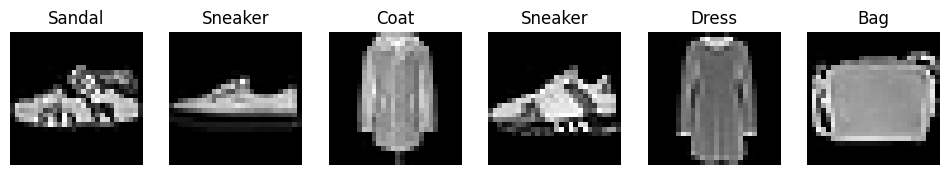

In [4]:
def show_samples():
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap="gray")
        axes[i].set_title(classes[labels[i]])
        axes[i].axis("off")
    plt.show()

show_samples()

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1 channel → 32 filters
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # 32 → 64 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # pooling reduces spatial size
        self.pool = nn.MaxPool2d(2, 2)

        # after two pools: 28×28 → 14×14 → 7×7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # Conv → ReLU → Pool
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)              # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


c:\Users\101031719\Documents\Image-Classification-on-the-Fashion-MNIST-Dataset-against-different-NN-models\.venv\Lib\site-packages\torch\cuda\__init__.py:182: UserWarning: cudaGetDeviceCount() returned cudaErrorNotSupported, likely using older driver or on CPU machine (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:88.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/5 - Loss: 0.4573
Epoch 2/5 - Loss: 0.2942
Epoch 3/5 - Loss: 0.2488
Epoch 4/5 - Loss: 0.2163
Epoch 5/5 - Loss: 0.1903


In [ ]:
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

mis_images = []
mis_preds = []
mis_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for img, pred, label in zip(images, predicted, labels):
            if pred != label:
                mis_images.append(img.cpu())
                mis_preds.append(pred.item())
                mis_labels.append(label.item())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 90.35%


<Figure size 1600x1200 with 0 Axes>

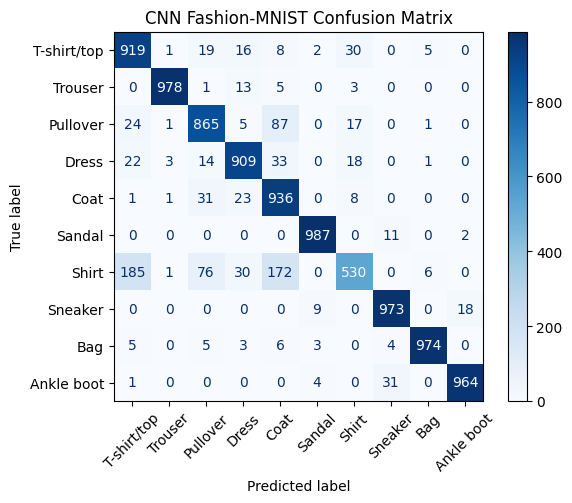

In [9]:

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(16, 12))
disp.plot(cmap="Blues", values_format="d")
plt.xticks(rotation=45)
plt.title("CNN Fashion-MNIST Confusion Matrix")
plt.show()


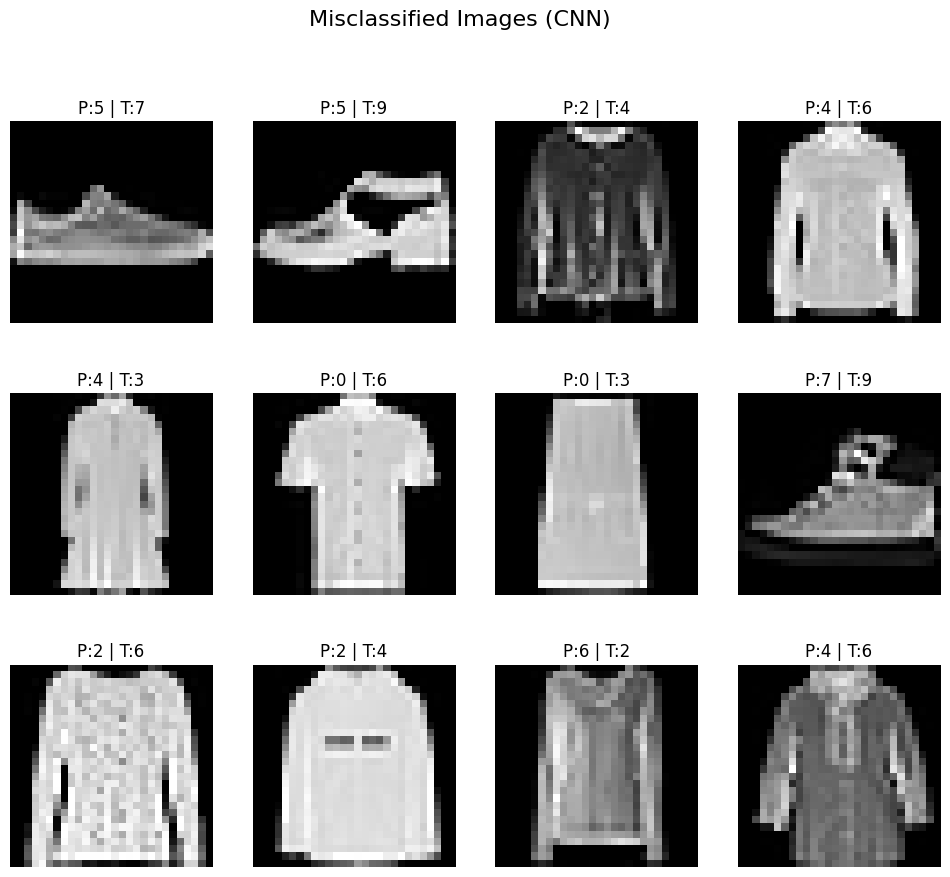

In [10]:

plt.figure(figsize=(12, 10))
num = 12

for i in range(num):
    plt.subplot(3, 4, i+1)
    plt.imshow(mis_images[i].squeeze(), cmap="gray")
    plt.title(f"P:{mis_preds[i]} | T:{mis_labels[i]}")
    plt.axis("off")

plt.suptitle("Misclassified Images (CNN)", fontsize=16)
plt.show()
